In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.integrate import quad
import vegas
plt.style.use("figures.mplstyle")

In [40]:
# constants

# muon beam
E_mu = 5000 # GeV
E_N = E_mu/2 # roughly speaking
m_mu = 0.106 # GeV
m_nucleon = 0.938 # GeV (proton mass)

# units
picobarn_to_cm2 = 1e-36 # cm^2
picobarn_to_m2 = 1e-40 # m^2


# Cherenkov light
n_air = 1.0003 # index of refraction
theta_C = np.arccos(1./n_air) # cherenkov angle
Ch_dN_dx = 2*np.pi/137 * np.sin(theta_C)**2 * (1/300 - 1/1000) * 1e9 # in m^-1

# balloon
L_det = 33e3 # m
R_det = 2 # m

# earth
N_avogadro = 6.022e23 # mol^-1
rho_earth = 2.65 # g/cm^3
A_earth = 1 # g/mol for average nucleon
n_earth = N_avogadro * rho_earth / A_earth # nucleons/cm^3
n_earth_m3 = n_earth * 1e6 # nucleons/m^3

In [41]:
def r_c_at_detector(theta_mu, phi, l_mu, z0):

    # origin of cherenkov light
    r0 = np.array([0,
                   l_mu * np.sin(theta_mu),
                   l_mu * np.cos(theta_mu) - z0])

    # cherenkov light direction
    pC_hat = np.array([-np.sin(theta_C)*np.sin(phi),
                       np.cos(phi)*np.cos(theta_mu)*np.sin(theta_C) + np.cos(theta_C)*np.sin(theta_mu),
                       -np.cos(phi)*np.sin(theta_mu)*np.sin(theta_C) + np.cos(theta_C)*np.cos(theta_mu)])

    t_star = (z0 - l_mu*np.cos(theta_mu)) / pC_hat[2] # time of intersection with detector plane

    return np.expand_dims(r0,-1) + pC_hat*t_star

def A(theta_mu, phi, l_mu, z0):

    r_c = r_c_at_detector(theta_mu, phi, l_mu, z0)
    return R_det**2 - r_c[0]**2 - r_c[1]**2



def F_c(theta_mu, l_mu, l_N):

    z0 = L_det - l_N

    result = quad(lambda phi: A(theta_mu, phi, l_mu, z0) > 0, 0, 2*np.pi)
    return result[0]/(2*np.pi)

def F_c_numerical(theta_mu, l_mu, l_N, N_sim=int(1e4)):

    z0 = L_det - l_N

    # # use vegas to do the integration
    # vegas_integrator = vegas.Integrator([[0, 2*np.pi]])
    # def integrand(phi):
    #     return np.where(A(theta_mu, phi, l_mu, z0) > 0,1.,0.)
    # result = vegas_integrator(integrand, nitn=10, neval=N_sim)
    # print(result.mean)
    # return result.mean

    phi_list = np.random.uniform(0,2*np.pi,N_sim)
    return sum(A(theta_mu,phi_list,l_mu,z0)>0) / len(phi_list)




In [42]:
N_points = 25
N_points_lookback = 100
lookback_length = L_det
l_N_range = np.linspace(L_det-lookback_length,L_det,N_points_lookback)
delta_l_mu_range = np.linspace(-150,150,N_points)
delta_l_width = delta_l_mu_range[1] - delta_l_mu_range[0] # always linear

F_c_arr = {}
N_gamma = {}
m_N_range_sparse = np.linspace(0.01,50,20) # GeV


for m_N in m_N_range_sparse:

    print("Calculating for m_N = %1.2f GeV"%m_N)

    theta_mu = m_N/E_N # roughly
    F_c_arr[m_N] = np.zeros((N_points_lookback,N_points))
    N_gamma[m_N] = np.zeros(N_points_lookback)

    for iN,l_N in enumerate(l_N_range):
        l_mu_max = (L_det - l_N)/(np.cos(theta_mu))
        l_mu_center = l_mu_max + theta_mu/theta_C*(l_N - L_det)
        _N_gamma = 0
        for imu,delta_l_mu in enumerate(delta_l_mu_range):
            l_mu = l_mu_center + delta_l_mu
            if l_mu > (L_det - l_N)/(np.cos(theta_mu)): continue
            F_c_arr[m_N][iN,imu] = F_c_numerical(theta_mu, l_mu, l_N, N_sim=int(1e4))
            _N_gamma += Ch_dN_dx * delta_l_width * F_c_arr[m_N][iN,imu]
        N_gamma[m_N][iN] = _N_gamma



Calculating for m_N = 0.01 GeV
Calculating for m_N = 2.64 GeV
Calculating for m_N = 2.64 GeV
Calculating for m_N = 5.27 GeV
Calculating for m_N = 5.27 GeV
Calculating for m_N = 7.90 GeV
Calculating for m_N = 7.90 GeV
Calculating for m_N = 10.53 GeV
Calculating for m_N = 10.53 GeV
Calculating for m_N = 13.17 GeV
Calculating for m_N = 13.17 GeV
Calculating for m_N = 15.80 GeV
Calculating for m_N = 15.80 GeV
Calculating for m_N = 18.43 GeV
Calculating for m_N = 18.43 GeV
Calculating for m_N = 21.06 GeV
Calculating for m_N = 21.06 GeV
Calculating for m_N = 23.69 GeV
Calculating for m_N = 23.69 GeV
Calculating for m_N = 26.32 GeV
Calculating for m_N = 26.32 GeV
Calculating for m_N = 28.95 GeV
Calculating for m_N = 28.95 GeV
Calculating for m_N = 31.58 GeV
Calculating for m_N = 31.58 GeV
Calculating for m_N = 34.21 GeV
Calculating for m_N = 34.21 GeV
Calculating for m_N = 36.84 GeV
Calculating for m_N = 36.84 GeV
Calculating for m_N = 39.48 GeV
Calculating for m_N = 39.48 GeV
Calculating for

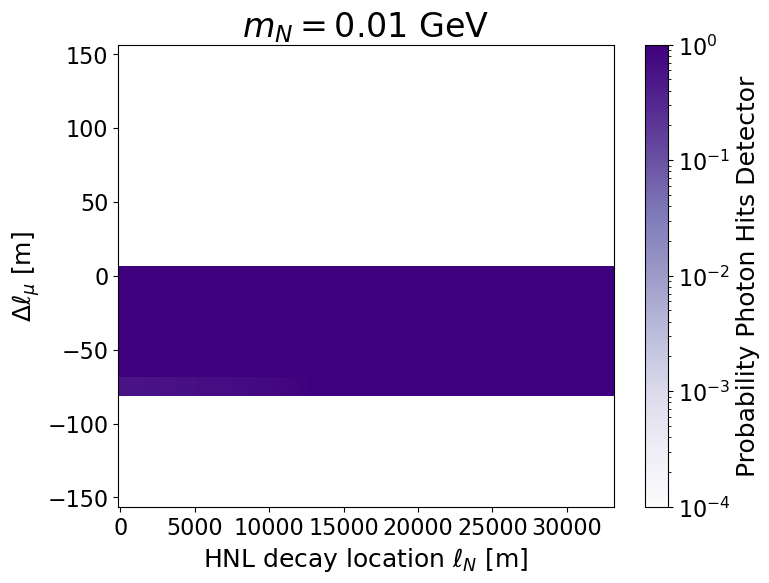

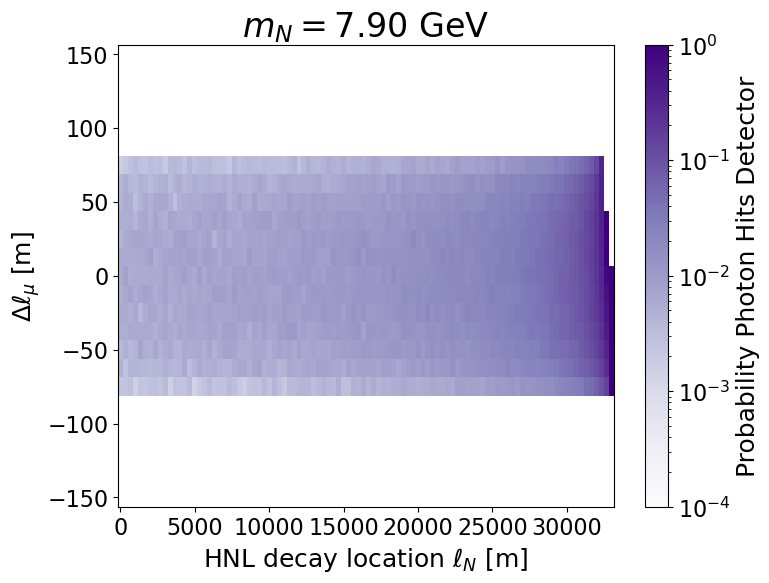

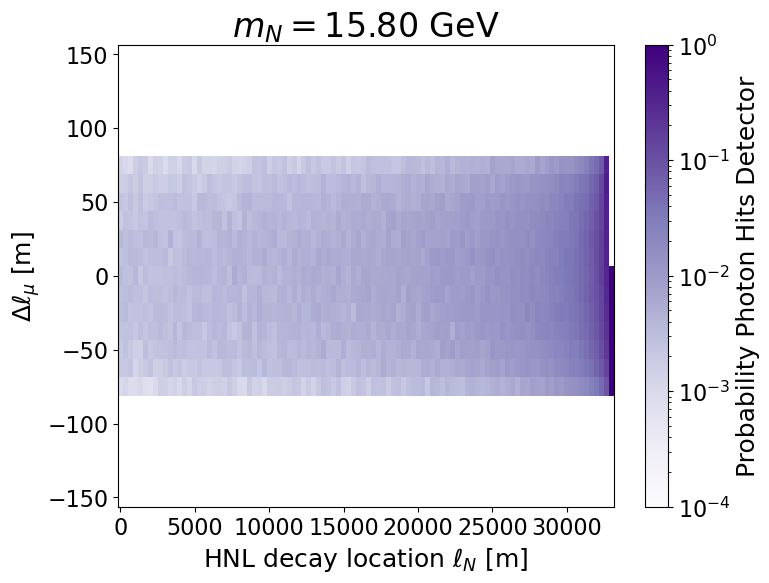

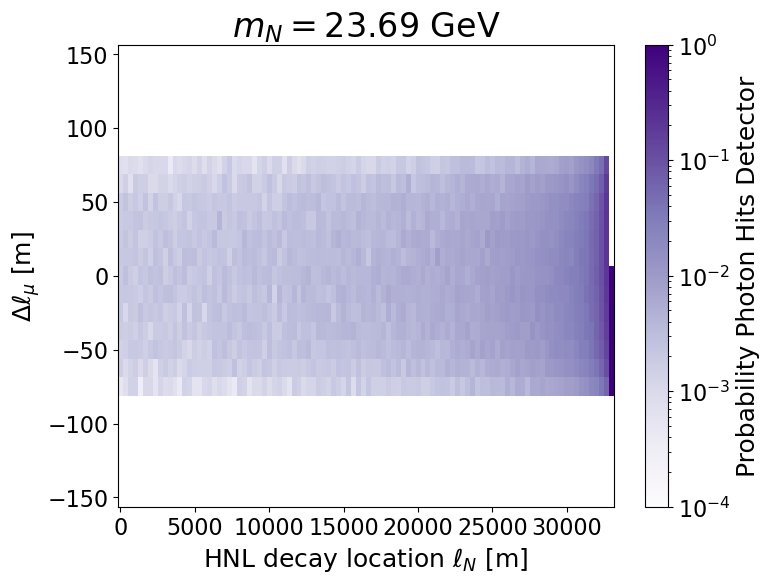

In [43]:
l_N_mesh,delta_l_mu_mesh = np.meshgrid(l_N_range,delta_l_mu_range)
for m_N in m_N_range_sparse[0:-10:3]:
    plt.pcolormesh(l_N_mesh,delta_l_mu_mesh,F_c_arr[m_N].T,norm=LogNorm(vmin=1e-4,vmax=1),shading='auto')
    plt.ylabel(r"$\Delta \ell_\mu$ [m]")
    plt.xlabel(r"HNL decay location $\ell_N$ [m]")
    c = plt.colorbar()
    c.set_label("Probability Photon Hits Detector")
    plt.title("$m_N = %1.2f$ GeV" % m_N)
    plt.show()

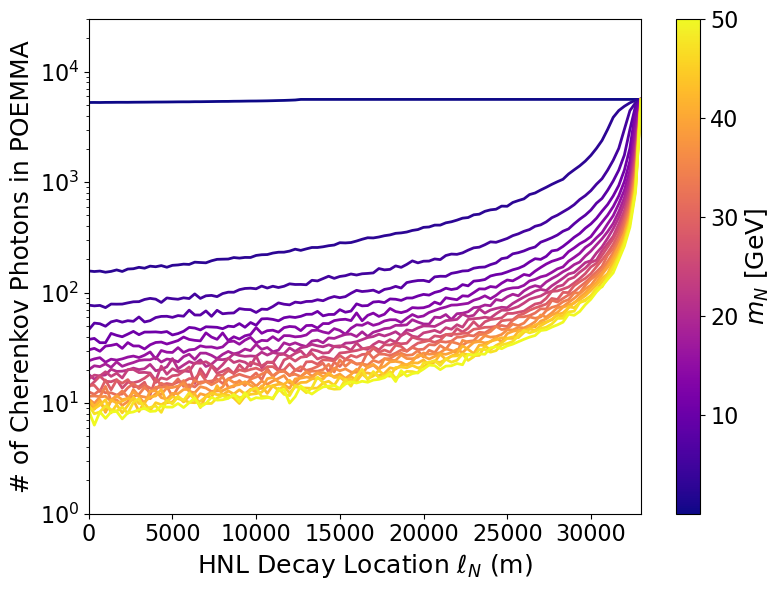

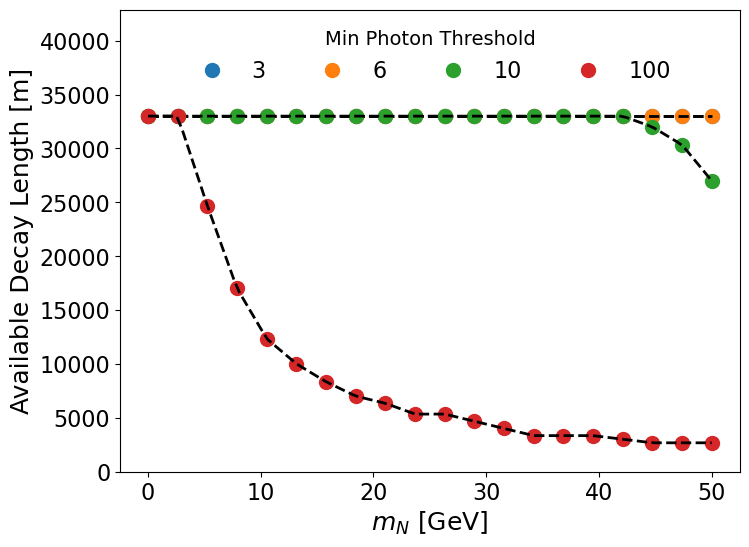

In [44]:
available_decay_length = {}
min_photon_points = [3,6,10,100]

# Use plasma colormap
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

# Normalize the mass range for colormap
m_N_array = np.array(list(m_N_range_sparse))
norm = Normalize(vmin=m_N_array.min(), vmax=m_N_array.max())
cmap = cm.plasma

# Smoothing parameter (sigma for Gaussian filter)
# Larger values = more smoothing. Try values between 1-5
smooth_sigma = 3

fig, ax = plt.subplots()
for m_N in m_N_range_sparse:
    color = cmap(norm(m_N))

    # Apply Gaussian smoothing
    #N_gamma_smooth = gaussian_filter1d(N_gamma[m_N], sigma=smooth_sigma)

    #ax.plot(l_N_range, N_gamma_smooth, color=color, linewidth=2)
    ax.plot(l_N_range, N_gamma[m_N], color=color, linewidth=2)

    for min_photons in min_photon_points:
        if min_photons not in available_decay_length.keys():
            available_decay_length[min_photons] = []
        # Use unsmoothed data for threshold calculation
        valid_points = l_N_range[N_gamma[m_N] >= min_photons]
        if len(valid_points) > 0:
            available_decay_length[min_photons].append(L_det - np.min(valid_points))
        else:
            available_decay_length[min_photons].append(0)

ax.set_yscale('log')
ax.set_xlabel(r"HNL Decay Location $\ell_N$ (m)")
ax.set_ylabel(r"# of Cherenkov Photons in POEMMA")
ax.set_xlim(l_N_range[0], l_N_range[-1])
ax.set_ylim(1, 3e4)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label=r'$m_N$ [GeV]')
plt.tight_layout()
plt.show()

# Plot available decay length
available_decay_length_interp = {}
for min_photons in min_photon_points:
    plt.plot(list(m_N_range_sparse), available_decay_length[min_photons],
             label=min_photons, marker='o',linewidth=0)
    available_decay_length_interp[min_photons] = interp1d(
        np.array(m_N_range_sparse),
        np.array(available_decay_length[min_photons]),
        kind='linear',
        fill_value="extrapolate"
    )
    plt.plot(np.linspace(m_N_range_sparse[0], m_N_range_sparse[-1], 100),
             available_decay_length_interp[min_photons](np.linspace(m_N_range_sparse[0], m_N_range_sparse[-1], 100)),
             color="black",linestyle='--')
plt.xlabel(r"$m_N$ [GeV]")
plt.ylabel("Available Decay Length [m]")
plt.legend(title="Min Photon Threshold",ncol=4,loc="upper center")
plt.ylim(0,1.3*L_det)
# plt.semilogy()
plt.show()

# Now for the event rate calculation

In [45]:
def l_N(E_mu, m_N, U2):
    return 3.3 * (10 / m_N)**6 * (1e-6 / U2) * (E_mu / 1500) # in meters

def sigma(E_mu, m_N, U2):
    s = 2 * m_nucleon * E_mu  # COM energy squared, nucleon at rest
    sqrt_s = np.sqrt(s)

    # Threshold behavior with smoothing
    # Use a form that transitions more smoothly near kinematic limits
    s_threshold = (m_N + m_mu)**2

    # Basic threshold factor
    if np.isscalar(m_N):
        if s <= s_threshold or m_N >= sqrt_s - m_mu:
            return 0.0
    else:
        mask = (s <= s_threshold) | (m_N >= sqrt_s - m_mu)

    # Simplified phase space with polynomial suppression near edges
    # This gives smoother behavior than Kallen function
    x = m_N / sqrt_s  # Fractional mass

    # Phase space factor that vanishes at x=0 and x~1
    # Using (1-x^2)^n form which is common for phase space
    phase_space = (1 - x**2)**10

    # Cross section
    sigma_val = 5e-1 * (s/320) * phase_space * U2  # in pb

    if not np.isscalar(m_N):
        sigma_val = np.where(mask, 0.0, sigma_val)

    return sigma_val * picobarn_to_m2  # convert to m^2


def event_rate(m_N,E_mu,U2,N_muon,L_det,L_target,buffer=10,min_photons=None):

    l_N_val = l_N(E_mu, m_N, U2)
    sigma_val = sigma(E_mu, m_N, U2)

    if min_photons is not None:
        buffer_proxy = L_det - available_decay_length_interp[min_photons](m_N)
        buffer = np.where(buffer_proxy > buffer, buffer_proxy, buffer)



    prefactor = N_muon * n_earth_m3 * sigma_val * l_N_val  # dimensionless
    long_lived_mask = l_N_val/(L_det + L_target + buffer) > 10
    prob_term = np.exp(-buffer / l_N_val) - np.exp(-L_det / l_N_val) - np.exp(-(L_target + buffer) / l_N_val) + np.exp(-(L_det + L_target) / l_N_val)
    prob_term_approx = ((L_det-buffer) * L_target) / (l_N_val**2)
    prob_term = np.where(long_lived_mask, prob_term_approx, prob_term)

    return prefactor * prob_term

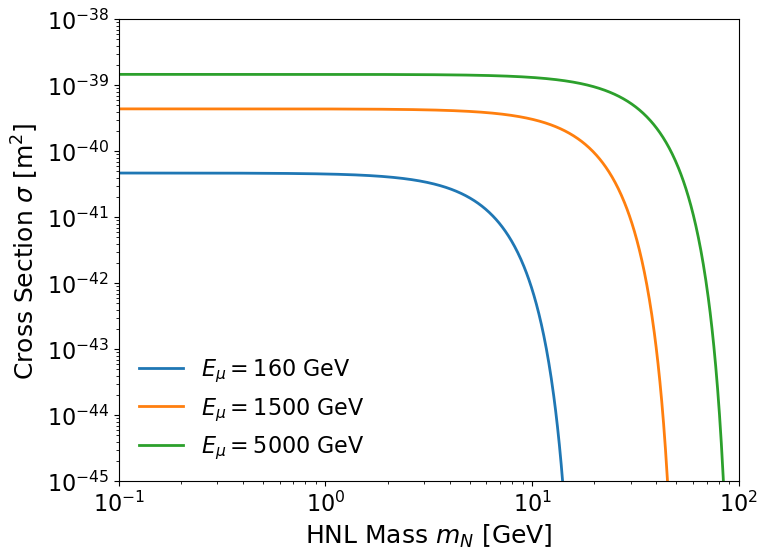

In [46]:
E_mu_range = [160,1500,5000]
m_N_range = np.logspace(-1,2,1000) # GeV
for E_mu in E_mu_range:
    plt.plot(m_N_range, sigma(E_mu, m_N_range, 1), label=f"$E_\\mu = {E_mu}$ GeV")
plt.loglog()
plt.legend()
plt.xlabel(r"HNL Mass $m_N$ [GeV]")
plt.ylabel(r"Cross Section $\sigma$ [m$^2$]")
plt.ylim(1e-45,1e-38)
plt.xlim(m_N_range[0],m_N_range[-1])
plt.show()

In [47]:
U2_range = np.logspace(-16,-2,100)

# E_mu = 1500 # GeV
# L_det = 33e3 # m
L_target = 1e3 / 3 # m

m_N_mesh,U2_mesh = np.meshgrid(m_N_range,U2_range)
rate_mesh_100 = event_rate(m_N_mesh, E_mu, U2_mesh, N_muon=1e22, L_det=L_det, L_target=L_target,min_photons=100)
rate_mesh_10 = event_rate(m_N_mesh, E_mu, U2_mesh, N_muon=1e22, L_det=L_det, L_target=L_target,min_photons=10)
rate_mesh_none = event_rate(m_N_mesh, E_mu, U2_mesh, N_muon=1e22, L_det=L_det, L_target=L_target,min_photons=None)

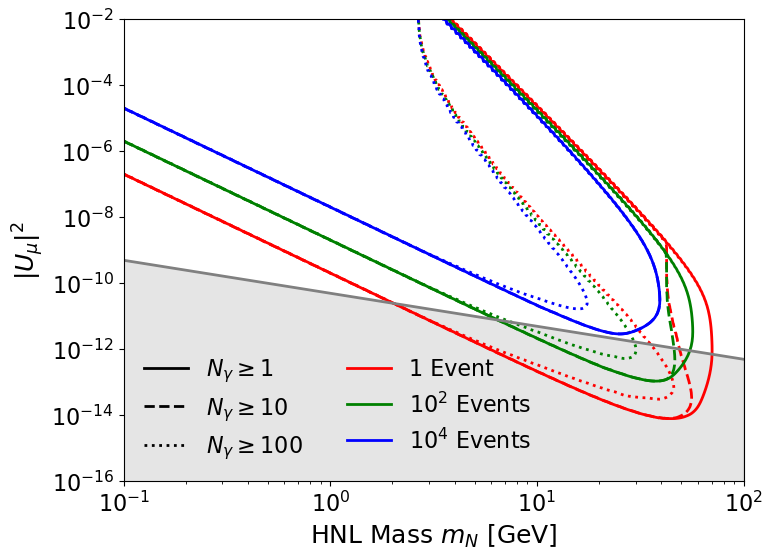

In [48]:
#plt.pcolormesh(m_N_mesh,U2_mesh,rate_mesh_none,norm=LogNorm(vmin=1e-2,vmax=1e10),shading='auto')
#c = plt.colorbar()
#c.set_label(r"Event Rate")
contours = plt.contour(m_N_mesh, U2_mesh, rate_mesh_10, levels=[1,1e2,1e4], colors=["red","green","blue"], linestyles='dashed')
contours = plt.contour(m_N_mesh, U2_mesh, rate_mesh_100, levels=[1,1e2,1e4], colors=["red","green","blue"], linestyles='dotted')
#plt.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')
contours_none = plt.contour(m_N_mesh, U2_mesh, rate_mesh_none, levels=[1,1e2,1e4], colors=["red","green","blue"], linestyles='solid')
plt.plot([],[], color="black", linestyle='solid', label=r'$N_{\gamma} \geq 1$')
plt.plot([],[], color="black", linestyle='dashed', label=r'$N_{\gamma} \geq 10$')
plt.plot([],[], color="black", linestyle='dotted', label=r'$N_{\gamma} \geq 100$')
plt.plot([],[], color="red", label = r"1 Event")
plt.plot([],[], color="green", label = r"$10^2$ Events")
plt.plot([],[], color="blue", label = r"$10^4$ Events")


# seesaw bound
U2_seesaw_upper = 5e-11 / m_N_range
plt.fill_between(m_N_range,0,U2_seesaw_upper,color="gray",alpha=0.2)
plt.plot(m_N_range,U2_seesaw_upper,color="gray")
#plt.text(0,0,"Seesaw")

plt.legend(ncol=2,loc="lower left")
plt.loglog()
plt.xlabel(r"HNL Mass $m_N$ [GeV]")
plt.ylabel(r"$|U_\mu|^2$")
plt.show()